# Research: Exploring the needs of UMCU researchers to share more data and software: a text mining approach
By K.Y. He, 5396131 

Utrecht University, July 9th 2021

# Import Packages

In [2]:
import pickle 
import pandas as pd
import numpy as np
import spacy
from tqdm.auto import tqdm
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from gensim.corpora import Dictionary
from scipy.interpolate import pchip
from collections import Counter
%matplotlib inline 

import gensim
import pyLDAvis
import pyLDAvis.gensim

import pandas as pd
from nltk.tokenize import RegexpTokenizer
import spacy
from collections import Counter
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn_wordcloud import venn2_wordcloud

# 1. Load the dataset

In [2]:
# load the dataset
df = pd.read_excel('/Users/KayiuH/Needs assessment for Open Science and FAIR data_ what are the gaps_(1-283).xlsx')


In [4]:
# Use only Q31 which is the open response answers
df1 = df['What would it take, in your opinion, for you to share more data/software with the public? Please try to name at least one thing.']

In [5]:
df1

0      A dedicated data support office which would mi...
1            Better knowledge of dedicated repositories 
2      patient sensitive data will never be openly sh...
3        Clear, institution broad guidelines and support
4       Clear UMC policies about privacy (patient data).
                             ...                        
278            More confidence in how to do it properly.
279    Example paragraphs for PIF/IC to allow for pub...
280    Practical support - datamanagement that handle...
281    If it requires less time. If there is support ...
282    I do not know if others can understand the dat...
Name: What would it take, in your opinion, for you to share more data/software with the public? Please try to name at least one thing., Length: 283, dtype: object

# 2. Pre-processing texts

The following data pre-processing steps will be used:
1. Remove newline characters
2. Apply NLP ‘spaCy’ for pre-processing
3. Tokenize the text
4. Clean words (lowering the text, remove punctuation and remove stop words)
5. Create Bigram and Trigram models
6. Remove rare and common tokens

In [6]:
# Pre-processing step 1
df2 = df1.astype('str') 
list2 = [x.replace('\n', ' ') for x in df2]

In [310]:
# Pre-processing step 2-3

import spacy
def processed_2(text):
    nlp = spacy.load("en_core_web_sm")
    processed_texts = [text for text in tqdm_notebook(nlp.pipe(text, 
                                              n_process=-1, # maximum number of threads
                                              disable=["ner",
                                                       "parser"]),
                                          total=len(text))]
    tokenized_texts = [[word.text.lower() for word in text
                        if not word.is_punct 
                        and not word.is_stop] 
                    for text in processed_texts]
    
    return (tokenized_texts)

In [311]:
processed_df1 = processed_2(list2)

In [312]:
# Pre-processing step 4
docs = processed_df1 

In [313]:
#Create Bigram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

In [314]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [315]:
# Pre-processing step 5
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=3, no_above=0.85)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 224
Number of documents: 283
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


# 3. Building LDA Mallet Model

In [320]:
mallet_path = "/Users/KayiuH/Downloads/mallet-2.0.8/bin/mallet" # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dictionary)

In [321]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(5, [('data', 0.32558139534883723), ('storage', 0.11627906976744186), ('management', 0.09302325581395349), ('publication', 0.08139534883720931), ('adequate', 0.05813953488372093), ('patients', 0.046511627906976744), ('study', 0.046511627906976744), ('paper', 0.046511627906976744), ('database', 0.03488372093023256), ('experience', 0.03488372093023256)]), (2, [('sharing', 0.484375), ('standards', 0.09375), ('quality', 0.078125), ('competition', 0.0625), ('encouraged', 0.0625), ('required', 0.046875), ('person', 0.046875), ('journals', 0.03125), ('2', 0.03125), ('small', 0.015625)]), (4, [('share', 0.5974025974025974), ('purpose', 0.06493506493506493), ('analysis', 0.05194805194805195), ('difficult', 0.05194805194805195), ('space', 0.05194805194805195), ('find', 0.05194805194805195), ('github', 0.03896103896103896), ('recognition', 0.025974025974025976), ('shared', 0.025974025974025976), ('standardized', 0.012987012987012988)]), (16, [('knowledge', 0.2222222222222222), ('training', 0.185

# 4. Find the optimal number of topics for LDA Mallet

In [326]:
# Define a function which computes coherence values
def compute_coherence_values2(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [327]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values2(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=4)

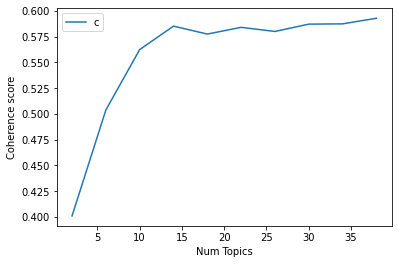

In [328]:
# Show graph
limit=40; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [329]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4011
Num Topics = 6  has Coherence Value of 0.5038
Num Topics = 10  has Coherence Value of 0.5624
Num Topics = 14  has Coherence Value of 0.5851
Num Topics = 18  has Coherence Value of 0.5774
Num Topics = 22  has Coherence Value of 0.5839
Num Topics = 26  has Coherence Value of 0.5799
Num Topics = 30  has Coherence Value of 0.587
Num Topics = 34  has Coherence Value of 0.5873
Num Topics = 38  has Coherence Value of 0.5927


# 5. Prominent topics in corpus

In [354]:
# Load the LDA MALLET model with 14 topics
lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=14,
                iterations= 1000)

transformed_docs = lda.load_document_topics()

In [356]:
# Make a dataframe with all topics and its distributions
N_TOPICS = 14 # Optimal number of topics
transformed_docs = lda.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(N_TOPICS)])
topic_distributions.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
0,0.064935,0.064935,0.064935,0.064935,0.101299,0.064935,0.083117,0.064935,0.064935,0.064935,0.064935,0.064935,0.101299,0.064935
1,0.067385,0.067385,0.067385,0.067385,0.086253,0.086253,0.067385,0.086253,0.067385,0.067385,0.067385,0.067385,0.067385,0.067385
2,0.057604,0.089862,0.073733,0.073733,0.073733,0.057604,0.073733,0.057604,0.122120,0.073733,0.057604,0.057604,0.057604,0.073733
3,0.066138,0.066138,0.066138,0.084656,0.066138,0.066138,0.066138,0.066138,0.066138,0.066138,0.103175,0.066138,0.084656,0.066138
4,0.064935,0.064935,0.064935,0.083117,0.064935,0.083117,0.083117,0.064935,0.064935,0.064935,0.083117,0.064935,0.083117,0.064935


In [357]:
# Print each word in the topic
for topic in range(N_TOPICS):
    words = lda.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: sharing easy problem adequate security institution existing burden accessible information
Topic 1: sharing people open patients guideline culture field analysis properly costs
Topic 2: research recognition clinical lack high division retrospective ethical protocol competition
Topic 3: privacy rules journals standards effort large processes clear established standardized
Topic 4: time software code institutional_guidelines dedicated misinterpretation stored easily arrange option
Topic 5: data knowledge process allowed group purpose based encouraged extra lot
Topic 6: patient institutional training public risk nan researcher platforms encouragement database
Topic 7: data repositories storage umcu system standard published financial years repository
Topic 8: data consent store informed informed_consent consuming find reduce team difficult
Topic 9: data shared guidance money mandatory infrastructure invest long place build
Topic 10: guidelines clear clear_guidelines good regulatio

# 6. Interpret topics based on visualization (word clouds)

In [358]:
import requests
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image
from wordcloud import WordCloud


# Define function to make word clouds based on the topic
def black_circle():
    response = requests.get('https://i.ibb.co/kHNWRYD/black-circle-better.png')
    circle_mask = np.array(Image.open(BytesIO(response.content)))
    return circle_mask 

def cloud(TOPIC2PLOT):
    circle_mask = black_circle()
    wordcloud = WordCloud(background_color='#fff',
                      font_path='/System/Library/Fonts/Supplemental/DIN Alternate Bold.ttf',
                    color_func=lambda *args, **kwargs: (0,0,0),
                     mask=circle_mask)
    wordcloud.generate_from_frequencies(frequencies=dict(lda.show_topic(TOPIC2PLOT, MAX_WORDS)))
    plt.axis("off")
    return plt.imshow(wordcloud, interpolation="bilinear")

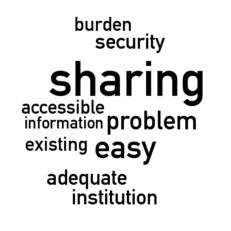

In [464]:
cloud(0)

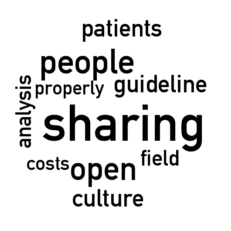

In [373]:
cloud(1)

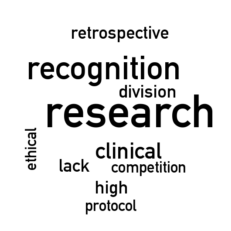

In [360]:
cloud(2)

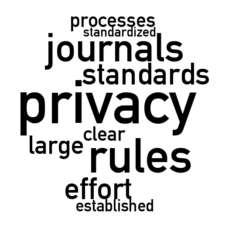

In [361]:
cloud(3)

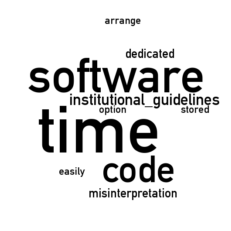

In [362]:
cloud(4)

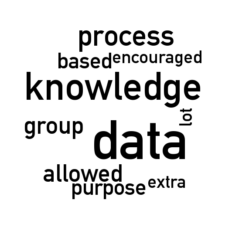

In [363]:
cloud(5)

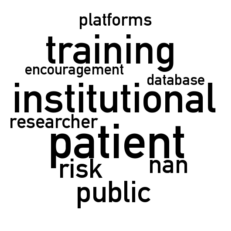

In [364]:
cloud(6)

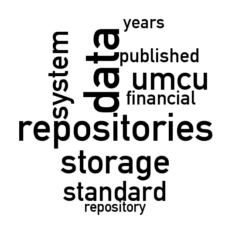

In [365]:
cloud(7)

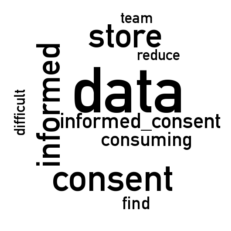

In [366]:
cloud(8)

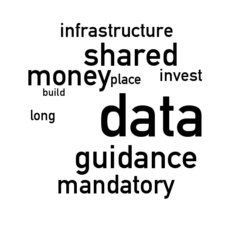

In [367]:
cloud(9)

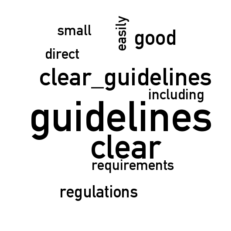

In [368]:
cloud(10)

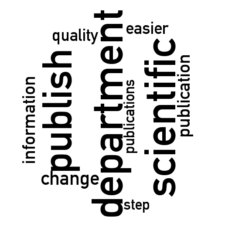

In [369]:
cloud(11)

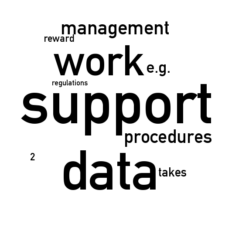

In [370]:
cloud(12)

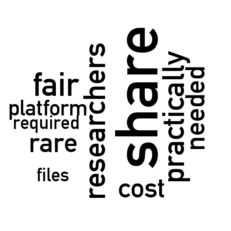

In [371]:
cloud(13)

# 7. One Word cloud

In [9]:
import spacy

def processed_3(text):
    nlp = spacy.load("en_core_web_sm")
    processed_texts = [text for text in nlp.pipe(text, 
                                              n_process=-1, # maximum number of threads
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.text.lower() for word in text
                        if not word.is_punct 
                        and not word.is_stop] 
                    for text in processed_texts]
    flatten = lambda t: [item for sublist in t for item in sublist]
    return flatten(tokenized_texts)

In [10]:
flatten_text = processed_3(list2)

print("Pre-processed: ", flatten_text[:50])

Pre-processed:  ['dedicated', 'data', 'support', 'office', 'minimize', 'time', 'investment', 'researcher', 'better', 'knowledge', 'dedicated', 'repositories', 'patient', 'sensitive', 'data', 'openly', 'shareable', 'proper', 'informed', 'consent', 'legal', 'agreements', 'intrested', 'discussing', 'opportunities', 'open', 'data', 'field', 'research', 'clear', 'institution', 'broad', 'guidelines', 'support', 'clear', 'umc', 'policies', 'privacy', 'patient', 'data', 'bit', 'encouragement', 'prior', 'submitting', 'manuscript', 'usually', 'upload', 'feel', 'obligated', 'ensuring']


In [378]:
def cloud2(text):
    circle_mask = black_circle()
    wordcloud = WordCloud(background_color='#fff',
                      font_path='/System/Library/Fonts/Supplemental/DIN Alternate Bold.ttf',
                    color_func=lambda *args, **kwargs: (0,0,0),
                     mask=circle_mask)
    word_could_dict=Counter(text)
    wordcloud.generate_from_frequencies(word_could_dict)
    plt.axis("off")
    plt.figure(figsize=(30,16))
    return plt.imshow(wordcloud, interpolation="bilinear")

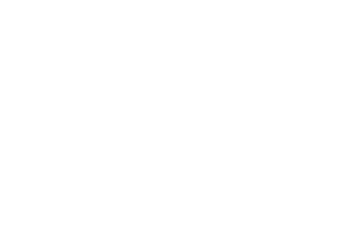

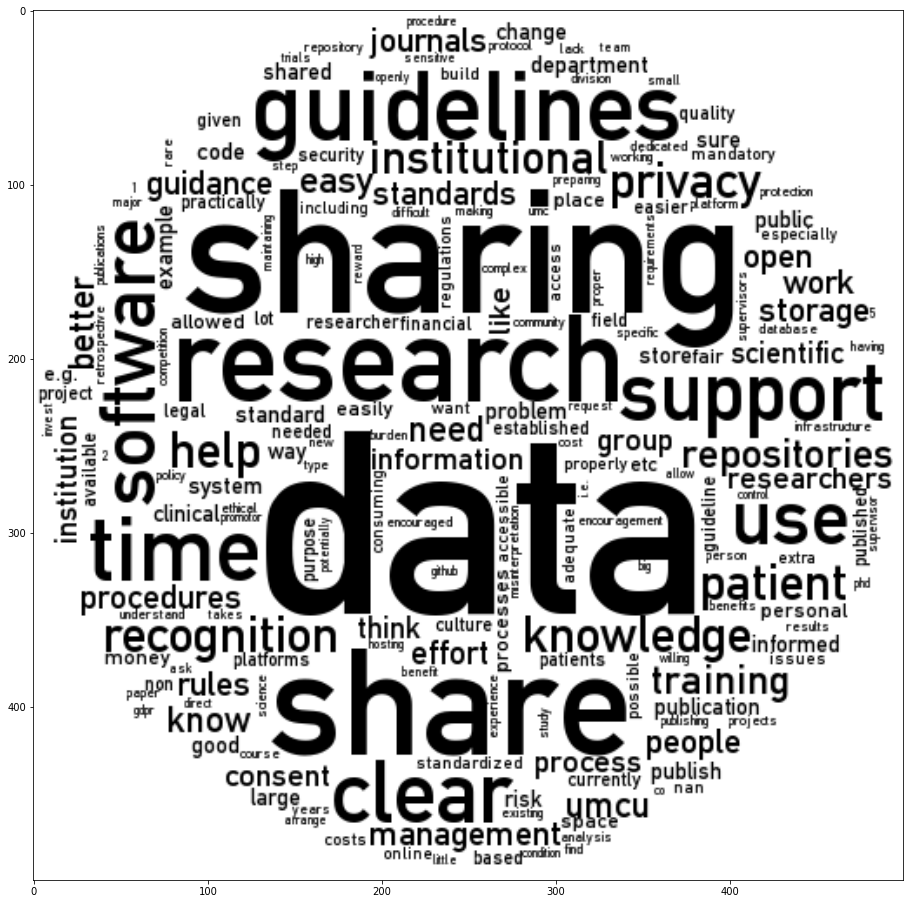

In [379]:
cloud2(flatten_text)

# 8. Load the Interview dataset

In [3]:
# load the datasets
df_i = pd.read_excel('/Users/KayiuH/Interviews_answers.xlsx')

# 9. Compare Survey response with Interview response

In [4]:
# Use only the interview responses
df_1 = df_i['Interview Answers Q31']

In [5]:
# Clean the data by removing new lines
df_2 = df_1.astype('str') 
list3 = [x.replace('\n', ' ') for x in df_2]

In [59]:
# Pre-process the interview response
interview_answers = processed_3(list3)

In [60]:
# Use the pre-processed survey response
survey_answers = flatten_text

# 10. Determine most distinctive words

In [61]:
# Define a function to get the most distinctive words
def d_words(corpus_1, corpus_2):
    counts_c1 = Counter(corpus_1)
    counts_c2 = Counter(corpus_2)
    vocabulary = set(list(counts_c1.keys()) + list(counts_c2.keys()))
    freq_c1_total = sum(counts_c1.values()) 
    freq_c2_total = sum(counts_c2.values()) 
    results = []
    for word in vocabulary:
        freq_c1 = counts_c1[word]
        freq_c2 = counts_c2[word]
        freq_c1_other = freq_c1_total - freq_c1
        freq_c2_other = freq_c2_total - freq_c2
        llr, p_value,_,_ = chi2_contingency([[freq_c1, freq_c2], 
                      [freq_c1_other, freq_c2_other]],
                      lambda_='log-likelihood') 
        if freq_c2 / freq_c2_other > freq_c1 / freq_c1_other:
            llr = -llr
        result = {'word':word, 
                    'llr':llr,
                    'p_value': p_value}
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

In [62]:
# The most distinctive words of survey answers compared to interview answers
d_word_1_2 = d_words(survey_answers, interview_answers)
print(d_word_1_2.sort_values('llr'))

# The most distinctive words of interview answers compared to survey answers 
d_word_2_1 = d_words(interview_answers, survey_answers)
print(d_word_2_1.sort_values('llr'))

               word        llr       p_value
30                  -34.716936  3.812999e-09
1428        science -33.163282  8.473560e-09
1015           open -22.772678  1.823396e-06
260             umc -19.670881  9.199253e-06
895         provide -16.157260  5.829469e-05
...             ...        ...           ...
864           group   5.881253  1.530293e-02
1172     procedures   6.814354  9.042800e-03
303        research  10.723285  1.057957e-03
35    institutional  12.588813  3.880624e-04
1344        sharing  19.219528  1.165154e-05

[1483 rows x 3 columns]
               word        llr       p_value
1344        sharing -19.219528  1.165154e-05
35    institutional -12.588813  3.880624e-04
303        research -10.723285  1.057957e-03
1172     procedures  -6.814354  9.042800e-03
864           group  -5.881253  1.530293e-02
...             ...        ...           ...
895         provide  16.157260  5.829469e-05
260             umc  19.670881  9.199253e-06
1015           open  22.772678

In [90]:
# Put all results into a seperate variable
d_words = d_word_1_2.append(d_word_2_1)

# Define the distinctive words and concatinate the results
# Made sure to sort them by log-likelihood and duplicate words are removed
d_word_1_2['type'] = 'Survey Answers'
d_word_2_1['type'] = 'Interview Answers'
d_words['type'] = 'Both'

results = pd.concat([d_word_1_2, d_word_2_1, d_words])
results = results.sort_values('llr', ascending = False).drop_duplicates(['word'])

# For the analysis, the thirty most distinctive words will be compared
top30_both = list(results[results.type == 'Both'].word.values[:30])
top30_1 = list(results[results.type == 'Survey Answers'].word.values[:30])
top30_2 = list(results[results.type == 'Interview Answers'].word.values[:30])

set1 = top30_both + top30_1
set2 = top30_both + top30_2

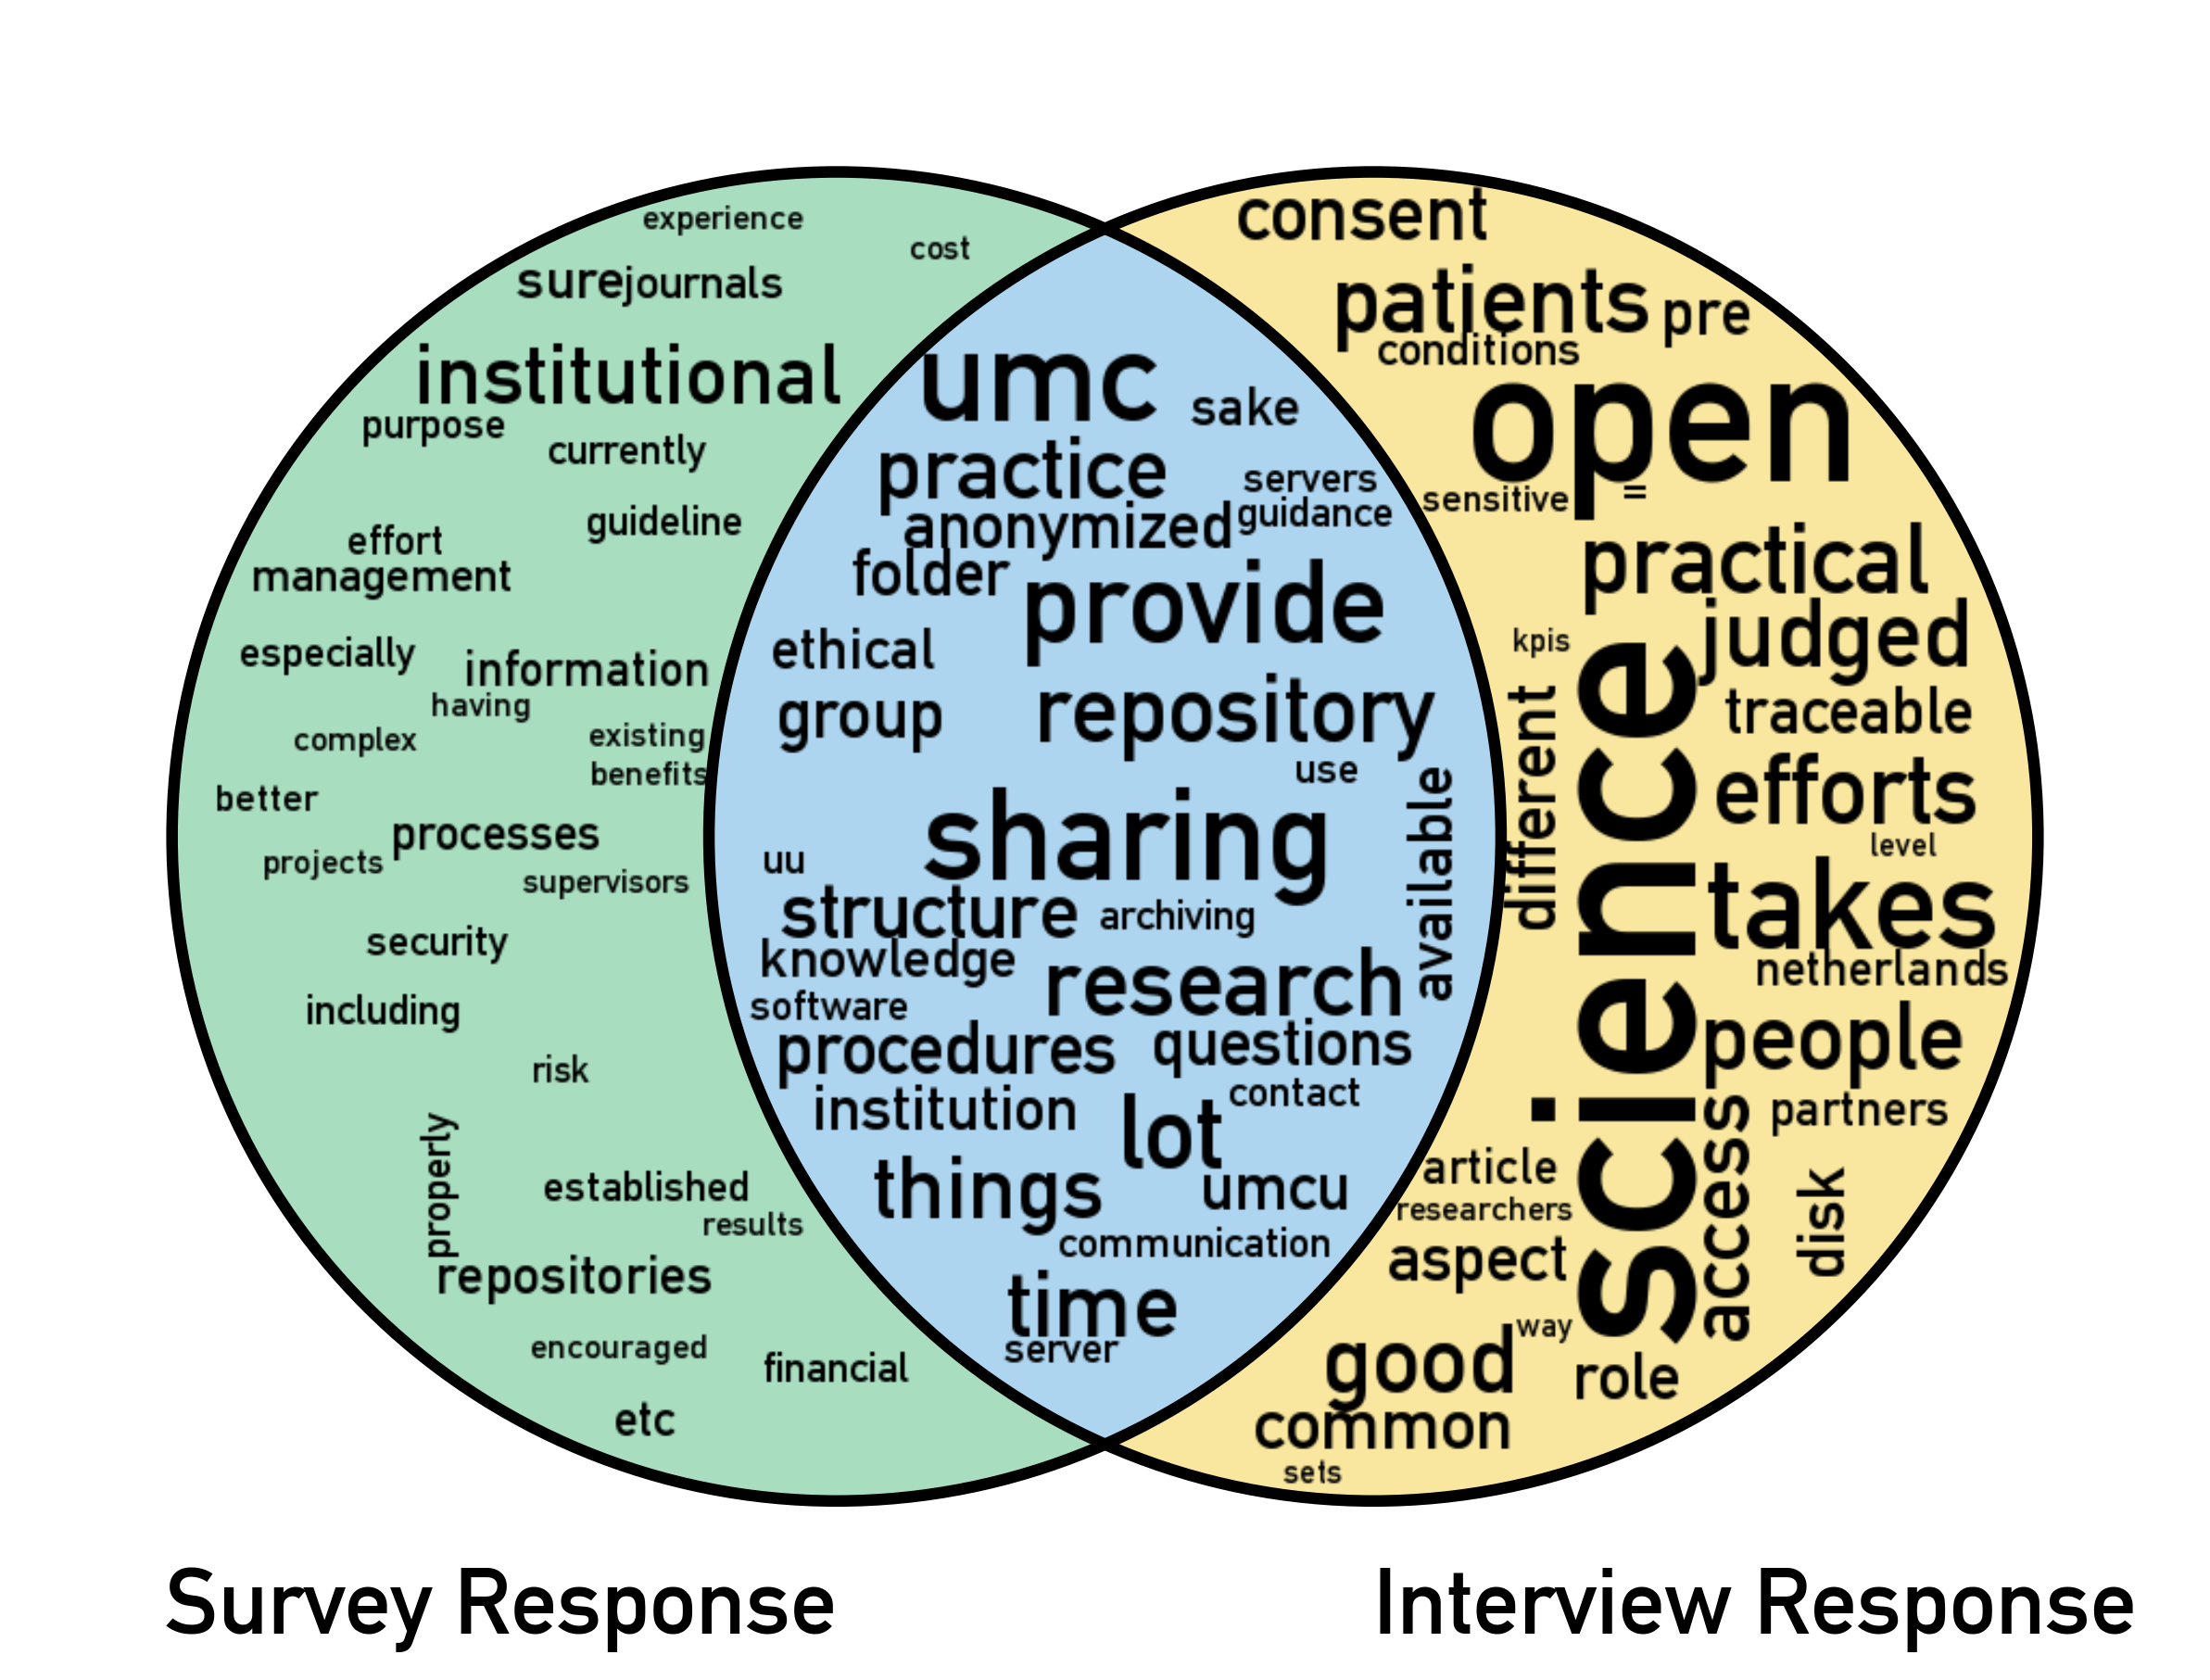

In [91]:
# Compute the diagram
word2freq = dict(zip(results.word, results.llr))

mpl.rcParams['font.family'] = 'DIN Alternate'
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10), dpi=300)

v = venn2_wordcloud([set(set1), set(set2)], 
                    ax=ax,
                    set_labels=['Survey Response', 'Interview Response'],
                   word_to_frequency=word2freq,
                    wordcloud_kwargs={'font_path': '/System/Library/Fonts/Supplemental/DIN Alternate Bold.ttf',
                                     'color_func':lambda *args, **kwargs: (0,0,0)})

v.get_patch_by_id('10').set_color('#27ae60')
v.get_patch_by_id('10').set_alpha(0.4)
v.get_patch_by_id('01').set_color('#f1c40f')
v.get_patch_by_id('01').set_alpha(0.4)
v.get_patch_by_id('11').set_color('#3498db')
v.get_patch_by_id('11').set_alpha(0.4)

In [95]:
print(set1)

['umc', 'sharing', 'provide', 'lot', 'research', 'repository', 'time', 'things', 'practice', 'structure', 'procedures', 'group', 'questions', 'anonymized', 'folder', 'umcu', 'available', 'institution', 'ethical', 'knowledge', 'uu', 'servers', 'sake', 'server', 'communication', 'archiving', 'guidance', 'software', 'use', 'contact', 'institutional', 'sure', 'repositories', 'processes', 'etc', 'information', 'management', 'journals', 'currently', 'security', 'especially', 'guideline', 'purpose', 'properly', 'including', 'established', 'financial', 'effort', 'better', 'risk', 'results', 'projects', 'supervisors', 'existing', 'having', 'cost', 'experience', 'encouraged', 'complex', 'benefits']


In [96]:
print(set2)

['umc', 'sharing', 'provide', 'lot', 'research', 'repository', 'time', 'things', 'practice', 'structure', 'procedures', 'group', 'questions', 'anonymized', 'folder', 'umcu', 'available', 'institution', 'ethical', 'knowledge', 'uu', 'servers', 'sake', 'server', 'communication', 'archiving', 'guidance', 'software', 'use', 'contact', ' ', 'science', 'open', 'takes', 'practical', 'efforts', 'patients', 'good', 'people', 'judged', 'access', 'consent', 'different', 'common', 'disk', 'role', 'netherlands', 'aspect', 'partners', 'article', 'pre', 'traceable', 'conditions', '=', 'sensitive', 'researchers', 'way', 'sets', 'kpis', 'level']


In [97]:
print(top30_1)

['institutional', 'sure', 'repositories', 'processes', 'etc', 'information', 'management', 'journals', 'currently', 'security', 'especially', 'guideline', 'purpose', 'properly', 'including', 'established', 'financial', 'effort', 'better', 'risk', 'results', 'projects', 'supervisors', 'existing', 'having', 'cost', 'experience', 'encouraged', 'complex', 'benefits']


In [98]:
print(top30_2)

[' ', 'science', 'open', 'takes', 'practical', 'efforts', 'patients', 'good', 'people', 'judged', 'access', 'consent', 'different', 'common', 'disk', 'role', 'netherlands', 'aspect', 'partners', 'article', 'pre', 'traceable', 'conditions', '=', 'sensitive', 'researchers', 'way', 'sets', 'kpis', 'level']
